In [1]:
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.colors import Normalize   
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import matplotlib.transforms
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
sns.set(font_scale=1.5)

In [2]:
table_path = Path('../../results/tables/')
product_path = Path('../../results/')

In [3]:
# Fix region names

def fix_region_name(roi):
    roi = roi.replace('_', ' ')
    roi = ' '.join(roi.split(',')[::-1]).strip()
    return roi

In [4]:
df_raw = pd.read_csv(table_path / 'fit_table_raw.csv')
df_raw['roi'] = df_raw['roi'].apply(fix_region_name)
df_raw = df_raw.set_index(['model', 'roi', 'quantile']).sort_index()

df = pd.read_csv(table_path / 'fit_table_reweighted.csv')
df['roi'] = df['roi'].apply(fix_region_name)
df = df.set_index(['roi', 'quantile']).sort_index()

In [5]:
# Add column for April 15th

def add_april_15th(df, stats):
    for stat in stats:
        df['%s (April 15th)' % stat] = df.filter(regex=("%s \(w.*" % stat)).apply(lambda x: x.dropna().get(-1, None), axis=1)
    return df

df = add_april_15th(df, ['Rt', 'car', 'ifr'])

In [13]:
def get_global(df):
    # Compute global stats
    df = df.drop('AA Global', errors='ignore')
    df.columns.name = 'param'
    means = df.unstack('roi').loc['mean'].unstack('param')
    weights = (1/df.unstack('roi').loc['std']**2).fillna(0).unstack('param')
    global_mean = (means*weights).sum() / weights.sum()
    global_sd = ((weights*((means - global_mean)**2)).sum()/weights.sum())**(1/2)
    df.loc[('GLOBAL', 'mean'), :] = global_mean
    df.loc[('GLOBAL', 'std'), :] = global_sd
    for quantile in ['0.025', '0.25', '0.5', '0.75', '0.975']:
        vals = df.unstack('roi').loc[quantile].unstack('param')
        df.loc[('GLOBAL', quantile), :] = (vals*weights).sum() / weights.sum()
    #df = df.sort_index()
    #gl = df.loc['Global']
    return df

df = get_global(df)
print(df.loc['GLOBAL',])

param           R0  Rt (week 0)  Rt (week 1)  Rt (week 2)  Rt (week 3)  \
quantile                                                                 
mean      2.882852     2.971610     2.785029     2.149676     1.780455   
std       1.533154     1.342869     1.172324     1.132778     0.995324   
0.025     1.315840     1.362250     1.321684     1.077972     0.936578   
0.25      1.938560     2.014962     1.925230     1.538539     1.314202   
0.5       2.535264     2.629421     2.480671     1.943126     1.630080   
0.75      3.417414     3.523581     3.287338     2.517300     2.072179   
0.975     6.485509     6.577314     6.016663     4.424468     3.491586   

param     Rt (week 4)      beta  car (week 0)  car (week 1)  car (week 2)  \
quantile                                                                    
mean         1.906909  0.378562      0.108202      0.112877      0.122458   
std          1.032846  0.169646      0.037475      0.056677      0.067371   
0.025        0.900544  0.

In [7]:
# Restrict ROIs for some analyses
rois = list(df.index.unique(level='roi'))
roi_us = sorted([r for r in rois if r[:3]=='US '])
top25 = pd.read_csv(product_path / "top25.csv", index_col=0, header=None).index
top25 = top25.map(fix_region_name)
roi_other = sorted(list(top25) + ['China'] + ['Australia'] + ['Canada'])
rois = roi_us + roi_other + ['GLOBAL']
df_top = df.loc[rois]
print("There are %d regions under consideration" % len(rois))

There are 59 regions under consideration


## Figures 

In [8]:
def clean_df(df, stat):
    result = df[stat].unstack('quantile')
    return result

def box_vs_roi(df, stat, labl, sort=True, low=0.12, high=22, palette=None, 
               ax=None, subtract=None, cscale=1):
    sns.set(font_scale=1.2, rc={'ytick.left': True, 'xtick.bottom': True})
    if ax is None:
        fig = plt.figure(figsize=(15, 5))
    else:
        fig = plt.gcf()
    clean = clean_df(df, stat)
    clean = clean.iloc[:, :5] # Only quantiles
    if sort is True:
        clean = clean.sort_values('0.5', ascending=False)
    elif sort is not False:
        clean = clean.loc[sort]
    clean = clean.loc[['GLOBAL'] + list(clean.index.drop('GLOBAL'))]
    if subtract:
        clean2 = clean_df(df, subtract)
        clean2 = clean2.loc[clean.index]
        clean2 = clean2.iloc[:, :5] # Only quantiles
#         diffs = np.log10(clean2['0.5'] / clean['0.5'])
#         cmap = cm.RdBu_r
#         norm = Normalize(vmin=-1, vmax=1)
        diffs =(clean['0.5'] - clean2['0.5'])
        cmap = cm.seismic
        norm = Normalize(vmin=-1*cscale, vmax=1*cscale)
        palette = [cmap(norm(diff)) for diff in diffs]
    else:
        palette = None
    ax = sns.boxplot(data=clean.T, whis=99, ax=ax, palette=palette)
    for i, box in enumerate(ax.artists):
        box.set_edgecolor('black')
        if palette is None:
            box.set_facecolor('white')
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=70);
    ax.set_yscale('log')
    if True:#'R' in stat:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,_: "%d"%x if x>=1 else '%.1g'%x))
        ax.yaxis.set_minor_formatter(FuncFormatter(lambda x,_: "%d"%x if x in [2, 5] else ''))
    dx = 8/72.; dy = 0/72. 
    ax.margins(x=0.01, y=0.01)
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
        label.set_transform(label.get_transform() + offset)
    ax.set_xlim(-1, len(clean))
    ax.set_ylim(low, high)
    ax.set_xlabel('')
    ax.set_ylabel(labl, fontsize=18);
    return list(clean.index)

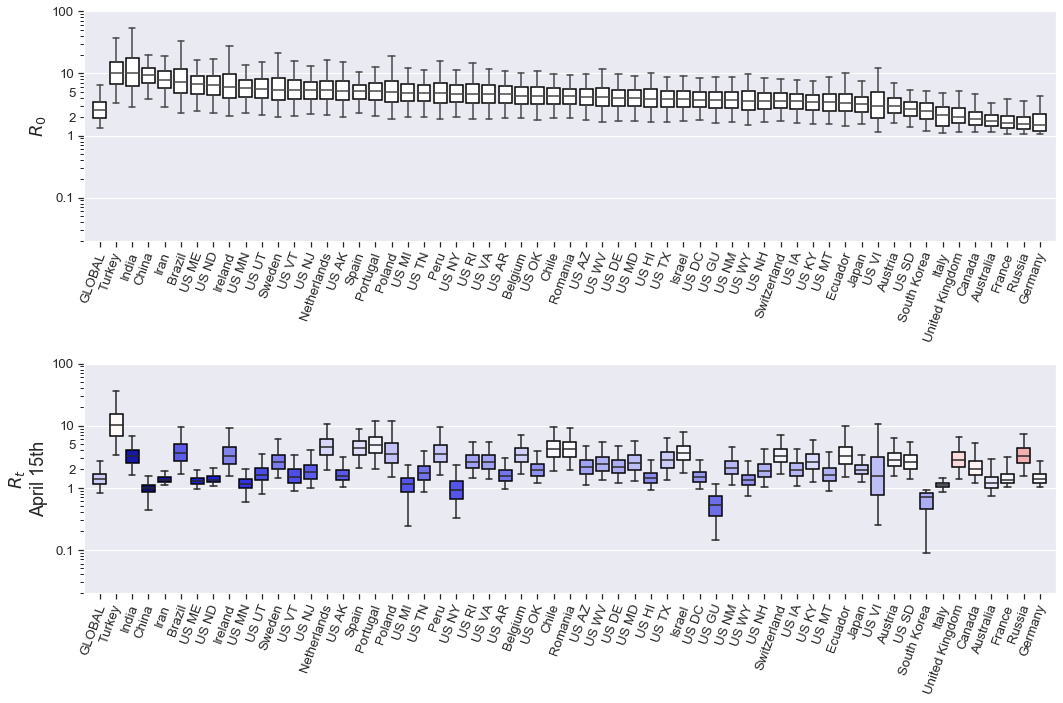

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sc = 10
rois = box_vs_roi(df_top, 'R0', '$R_0$', ax=ax[0], low=0.02, high=100, cscale=sc);
box_vs_roi(df_top, 'Rt (April 15th)', '$R_t$\nApril 15th', low=0.02, high=100, ax=ax[1], subtract='R0', sort=rois, cscale=sc);
plt.tight_layout()
plt.savefig(product_path / 'fig_r.png', dpi=400)

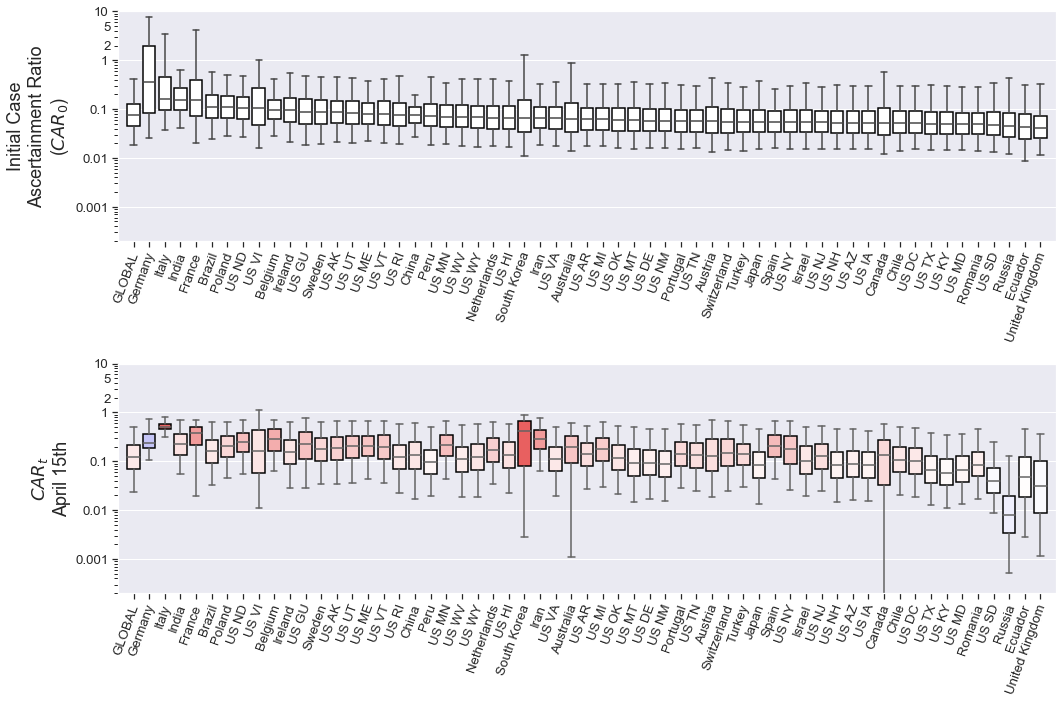

In [11]:
# Figure 3
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sc = 1
rois = box_vs_roi(df_top, 'car (week 0)', 'Initial Case\nAscertainment Ratio\n($CAR_0$)', ax=ax[0], low=0.0002, high=10,cscale=sc);
box_vs_roi(df_top, 'car (April 15th)', '$CAR_t$\nApril 15th', low=0.0002, high=10, ax=ax[1], subtract='car (week 0)', cscale=sc,sort=rois);
plt.tight_layout()
plt.savefig(product_path / 'fig_car.png', dpi=400)

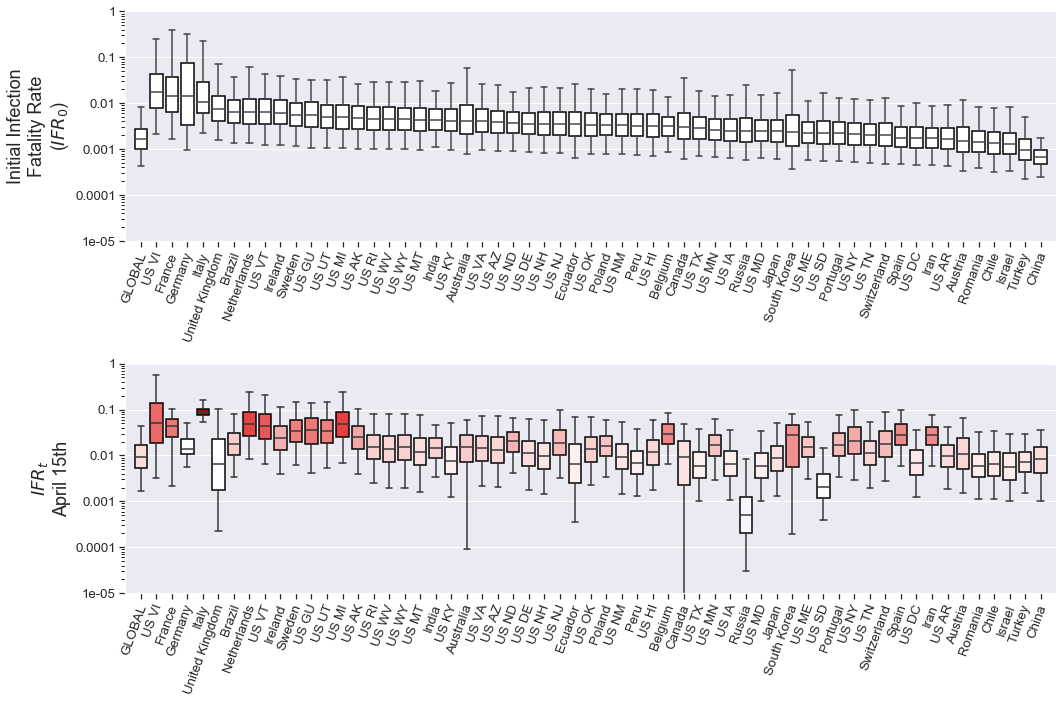

In [12]:
# Figure 4
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sc = 0.1
rois = box_vs_roi(df_top, 'ifr (week 0)', 'Initial Infection\nFatality Rate\n($IFR_0$)', ax=ax[0], low=1e-5, high=1, cscale=sc);
box_vs_roi(df_top, 'ifr (April 15th)', '$IFR_t$\nApril 15th', low=1e-5, high=1, ax=ax[1], subtract='ifr (week 0)', sort=rois, cscale=sc);
plt.tight_layout()
plt.savefig(product_path / 'fiq_ifr.png', dpi=400)

In [ ]:
# # Figure 5
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# rois = box_vs_roi(df_top, 'q', 'Relative Infectiousness\nof Known Cases\n($q$)', ax=ax, low=1e-3, high=1);
# plt.tight_layout()
# plt.savefig('fig_q.png', dpi=400)

### Figures 5-6

In [ ]:
# # Figure 5
# sns.set(style='dark', font_scale=1.2, rc={'ytick.left': True, 'ytick.right': False})
# quantiles = ['0.025', '0.25', '0.5', '0.75', '0.975']
# fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
# for i, pair in enumerate([('R0', 'Rt (April 15th)'), ('car (week 0)', 'car (April 15th)'), ('ifr (week 0)', 'ifr (April 15th)')]):
#     ax = axes.flat[i]
#     sns.boxplot(data=gl.loc[quantiles, pair], whis=99, ax=ax)
#     ax.set_xlabel('');
#     ax.set_yscale('log')
# #axes.flat[0].set_yticks(range(9))
# axes.flat[0].set_xticklabels(['Initial', 'April 15th'])
# axes.flat[0].set_ylabel('$R_t$')
# axes.flat[1].set_ylabel('$CAR_t$')
# axes.flat[2].set_ylabel('$IFR_t$')

# xticks = [1, 3, 10]
# ax = axes.flat[0]
# ax.set_yticks(xticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks([1.02, 1.25, 1.5, 2, 3, 5, 10])
# axt.set_yticklabels(['%.2g' % (1 - 1/x) for x in axt.get_yticks()])
# axt.set_ylabel('Herd Immunity Threshold')

# xticks = [0.1, 1]
# ax = axes.flat[1]
# ax.set_yticks(xticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks([1/21, 1/11, 1/6, 1/4, 1/2])
# axt.set_yticklabels(['%d' % (1/x - 1) for x in axt.get_yticks()])
# axt.set_ylabel('# of unreported infections\nfor each reported case')


# xticks = [0.001, 0.01, 0.1]
# ax = axes.flat[2]
# ax.set_yticks(xticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks([1/1001, 1/501, 1/201, 1/101, 1/51, 1/21, 1/11])
# axt.set_yticklabels(['%d' % (1/x - 1) for x in axt.get_yticks()])
# axt.set_ylabel('# of total infections\nper case death')

# plt.tight_layout()

In [ ]:
# # Figure 6
# sns.set(style='dark', font_scale=1.5)
# ax = sns.boxplot(data=gl.loc[quantiles, ['q']], whis=99)
# ax.set_yscale('log')
# yticks = [0.003, 0.01, 0.03, 0.1, 0.3, 1]
# ax.set_yticks(yticks)
# ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# ax.set_ylabel('Infectiousness of known\ninfectedrelative to\nunknown infected ($q$)')
# ax.set_xticklabels(['Global Average'])
# ax.set_xlabel('')
# axt = ax.twinx()
# axt.set_yscale('log')
# axt.set_ylim(*ax.get_ylim())
# axt.minorticks_off()
# axt.set_yticks(yticks)
# axt.set_yticklabels(['%d' % (1/x) for x in axt.get_yticks()])
# axt.set_ylabel('Fold reduction\nin infectiousness');

In [ ]:
#import sys
#sys.path.insert(0, '/home/rgerkin/covid-sicr/Stan')
#from __init__ import reweighted_stats
#reweighted_stats('/home/rgerkin/covid-sicr/fits/fit_table_raw.csv')

In [ ]:
# # Model comparison
# import pandas as pd

# df = df_raw.set_index(['quantile'])
# df = df[df['roi'] != 'Gambia']
# #df = df[df['roi'].str.contains('US_')]
# df = df.loc['0.5'][['model', 'roi', 'waic', 'loo']].set_index('roi')#reset_index()
# fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)
# #sns.violinplot(data=df, x='model', y='waic')
# #sns.set(font_scale=1.5)
# for i, kind in enumerate(['waic', 'loo']):
#     sns.stripplot(data=df, y='model', x=kind, ax=ax[i], orient='h', alpha=0.5,
#                   order=['nonlinearmodel', 'nonlinearmodelq0ctime', 'fulllinearmodel',
#                          'reducedlinearmodelNegBinom', 'reducedlinearmodelq0', 'reducedlinearmodelq0ctime'])
#     #ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=80);
#     ax[i].set_xscale('log')
#     ax[i].set_ylabel('')
# plt.tight_layout()

### The End

In [ ]:
# def stat_vs_stat(df, stat1, stat2):
#     sns.set(font_scale=1.5, rc={'xtick.bottom': True, 'ytick.left': True, 'xtick.top': True, 'ytick.right': True})
#     fig = plt.figure(figsize=(10, 10))
#     clean1 = clean_df(df, stat1)
#     clean2 = clean_df(df, stat2)
#     plt.errorbar(clean1['0.5'], clean2['0.5'],
#                  xerr=clean1['std'], yerr=clean2['std'],
#                  color='b', marker='o', ls='none', alpha=0.5)
#     plt.xscale('log')
#     plt.yscale('log')
#     import matplotlib.transforms
#     dx = 7/72.; dy = 0/72. 
#     #ax.margins(x=0.01, y=0.01)
#     offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
#     for label in plt.gca().get_xticklabels():
#         label.set_horizontalalignment('right')
#         label.set_transform(label.get_transform() + offset)
#     low = 0.08
#     high = 15
#     plt.plot([low, high], [low, high], 'k--')
#     plt.xlim(0.8, 15)
#     plt.ylim(0.12, 15)
#     plt.xlabel('$R_0$\n(first cases in region)');
#     plt.ylabel('$R_t$\n(April 15th, 2020)');
    
#stat_vs_stat(df, 'R0', 'Rt (April 15th)');